In [1]:
from imutils.perspective import four_point_transform
import matplotlib.pyplot as plt
import cv2
import os

In [2]:
def plt_imshow(title='image', img=None, figsize=(8 ,5)):
    plt.figure(figsize=figsize)
 
    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []
 
            for i in range(len(img)):
                titles.append(title)
 
        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
 
            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])
 
        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
 
        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()


In [3]:
import imutils

def make_scan_image(image, width, ksize=(5,5), min_threshold=75, max_threshold=200):
  image_list_title = []
  image_list = []
 
  org_image = image.copy()
  image = imutils.resize(image, width=width)
  ratio = org_image.shape[1] / float(image.shape[1])
 
  # 이미지를 grayscale로 변환하고 blur를 적용
  # 모서리를 찾기위한 이미지 연산
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, ksize, 0)
  edged = cv2.Canny(blurred, min_threshold, max_threshold)
 
  image_list_title = ['gray', 'blurred', 'edged']
  image_list = [gray, blurred, edged]
 
  # contours를 찾아 크기순으로 정렬
  cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
 
  findCnt = None
 
  # 정렬된 contours를 반복문으로 수행하며 4개의 꼭지점을 갖는 도형을 검출
  for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
 
    # contours가 크기순으로 정렬되어 있기때문에 제일 첫번째 사각형을 영역으로 판단하고 break
    if len(approx) == 4:
      findCnt = approx
      break
 
  # 만약 추출한 윤곽이 없을 경우 오류
  if findCnt is None:
    raise Exception(("Could not find outline."))
 
  output = image.copy()
  cv2.drawContours(output, [findCnt], -1, (0, 255, 0), 2)
  
  image_list_title.append("Outline")
  image_list.append(output)
 
  # 원본 이미지에 찾은 윤곽을 기준으로 이미지를 보정
  transform_image = four_point_transform(org_image, findCnt.reshape(4, 2) * ratio)
  # remove border
  image_gray = cv2.cvtColor(transform_image, cv2.COLOR_BGR2GRAY)
  ret, thresh = cv2.threshold(image_gray, 127, 255, 0)

  contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  result_image = cv2.drawContours(thresh, contours, -1, (255, 255, 255), 100)
  plt_imshow(image_list_title, image_list)
  plt_imshow('transform image', transform_image)
 
  return result_image

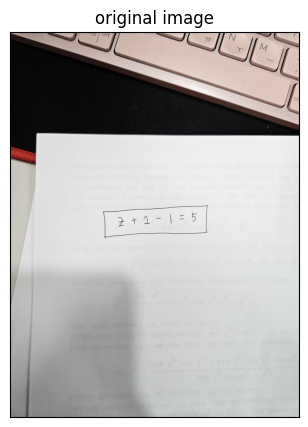

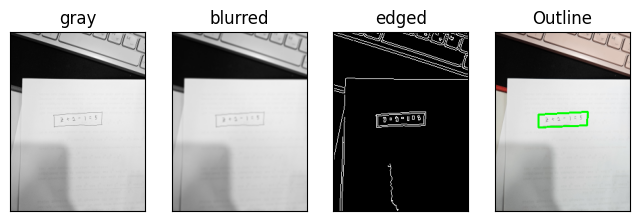

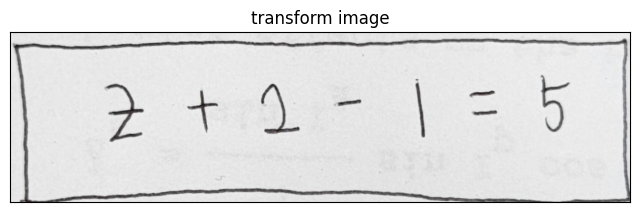

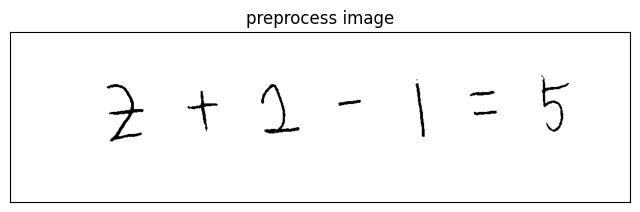

In [4]:
# Import the modules
from skimage.feature import hog
import numpy as np
import matplotlib.pyplot as plt
 
# Read the input image 
im = cv2.imread("../data/test/test2.jpg")

plt_imshow('original image', im)

# dilation kernal
kernel = np.ones((3, 3), np.uint8)

dilation = cv2.erode(im, kernel, iterations=6)
# im = dilation

im = make_scan_image(im, width=200, ksize=(3, 3), min_threshold=20, max_threshold=80)

plt_imshow('preprocess image', im)

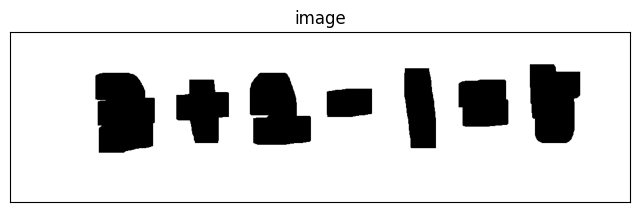

In [6]:
img = im

kernel = np.ones((9,9), np.uint8)

erosion = cv2.erode(img, kernel, iterations=5)
# dilation = cv2.dilate(img, kernel, iterations=1)

plt_imshow('image', erosion)
# plt_imshow('dilation', dilation)

In [7]:
def padding(img, set_size):

    try:
        h,w = img.shape
    except:
        print('파일을 확인후 다시 시작하세요.')
        raise

    if h < w:
        new_width = set_size
        new_height = int(new_width * (h/w))
    else:
        new_height = set_size
        new_width = int(new_height * (w/h))

    if max(h, w) < set_size:
        img = cv2.resize(img, (new_width, new_height), cv2.INTER_CUBIC)
    else:
        img = cv2.resize(img, (new_width, new_height), cv2.INTER_AREA)

 
    try:
        h,w = img.shape
    except:
        print('파일을 확인후 다시 시작하세요.')
        raise

    delta_w = set_size - w
    delta_h = set_size - h
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    new_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[255, 255, 255])

    return new_img

In [8]:
def padding2(image):
    height, width = image.shape
    
    if width == height:
        return image
    elif width > height:
        dif = width - height
        image = cv2.copyMakeBorder(image, dif//2, dif//2, 0, 0, cv2.BORDER_REPLICATE, value=[255,255,255] )
        return image
    else:
        dif = height - width
        image = cv2.copyMakeBorder(image,0,0, dif//2, dif//2, cv2.BORDER_REPLICATE, value=[255,255,255] )
        return image

original image width: 1096, height: 300


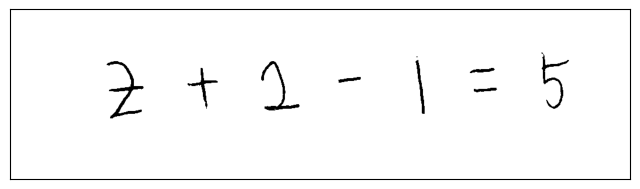

[[151, 72], [294, 84], [424, 72], [560, 100], [697, 64], [793, 84], [919, 57]]


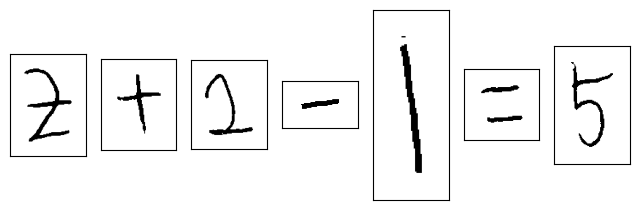

In [9]:
im_gray = cv2.GaussianBlur(erosion, (5, 5), 0)
 
# Threshold the image
ret, im_th = cv2.threshold(im_gray, 90, 255, cv2.THRESH_BINARY_INV)
 
# Find contours in the image
ctrs, hier = cv2.findContours(im_th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
 
# Get rectangles contains each contour
rects = [cv2.boundingRect(ctr) for ctr in ctrs]
rects.sort(key=lambda x:x[0])
rect_imgs = [] 
 
# For each rectangular region
count = 0
img_coordinate = []
for rect in rects:
    # Draw the rectangles
    
    # rectangle on the original image
    # cv2.rectangle(im, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 3) 
 
    # Make the rectangular region around the digit
    
    # leng = int(rect[3] * 1.6)
    # pt1 = int(rect[1] + rect[3] // 2 - leng // 2)
    # pt2 = int(rect[0] + rect[2] // 2 - leng // 2)
    pt1 = rect[1]
    pt2 = rect[0]
    ptx = rect[2]
    pty = rect[3]
    
    # [startY:endY, startX:endX]
    roi = im[pt1:pt1+pty, pt2:pt2+ptx]
    if roi.size <= 0:
        continue
    
    count += 1
    # print(count)
    # Resize the image
    rect_imgs.append(roi)
    roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
    se = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 7))
    roi = cv2.dilate(roi, se)
    img_coordinate.append([pt2, pt1])
    
count = 0
save_path = '../data/output/'

if not os.path.isdir(save_path):
    os.mkdir(save_path)

for f in os.listdir(save_path):
    os.remove(os.path.join(save_path, f))

for img in rect_imgs:
    img = padding(img, 45)
    # img = padding2(img)
    cv2.imwrite(f'{save_path}/{count}.jpg', img)
    count += 1

h, w = im.shape

print(f'original image width: {w}, height: {h}')
plt_imshow('', img=im)
print(img_coordinate)
plt_imshow('', img=rect_imgs)